
##DATA 512 - Homework 1



@Author: Hema Varshita Muppalla

This notebook contains code to construct and analyze a dataset of monthly article traffic for a select set of pages from English Wikipedia from July 1, 2015 through September 30, 2023.

##STEP 1: DATA ACQUISITION

The code below allows to collect web traffic data from the Pageviews API.

1. [Pageviews API](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)
2. [Pageviews Documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews)

First, we import necessary packages

In [ ]:

# These are standard python modules
import json, time, urllib.parse
import pandas as pd
import json
import matplotlib.pyplot as plt
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

Constants that will be used across the notebook and allow the code to be more readable.


In [ ]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<hmuppa@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}

Extracting article titles of academy award winning movies.

In [ ]:
article_df = pd.read_excel('thank_the_academy.AUG.2023.csv.xlsx')
ARTICLE_TITLES = article_df['name'].to_list()

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. The parameters that will change are access_type, which mentions if access was on desktop or mobile and article_title

In [ ]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None,
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template

    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")


    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access_type

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Let's take a look at a sample API Call from the Pageview API for the movie - "All Quiet on the Western Front"

In [ ]:
print("Getting pageview data for: ",ARTICLE_TITLES[1])
views = request_pageviews_per_article(ARTICLE_TITLES[1],'desktop')
views

Getting pageview data for:  All Quiet on the Western Front (2022 film)


{'items': [{'project': 'en.wikipedia',
   'article': 'All_Quiet_on_the_Western_Front_(2022_film)',
   'granularity': 'monthly',
   'timestamp': '2021100100',
   'access': 'desktop',
   'agent': 'user',
   'views': 856},
  {'project': 'en.wikipedia',
   'article': 'All_Quiet_on_the_Western_Front_(2022_film)',
   'granularity': 'monthly',
   'timestamp': '2021110100',
   'access': 'desktop',
   'agent': 'user',
   'views': 1306},
  {'project': 'en.wikipedia',
   'article': 'All_Quiet_on_the_Western_Front_(2022_film)',
   'granularity': 'monthly',
   'timestamp': '2021120100',
   'access': 'desktop',
   'agent': 'user',
   'views': 1652},
  {'project': 'en.wikipedia',
   'article': 'All_Quiet_on_the_Western_Front_(2022_film)',
   'granularity': 'monthly',
   'timestamp': '2022010100',
   'access': 'desktop',
   'agent': 'user',
   'views': 2178},
  {'project': 'en.wikipedia',
   'article': 'All_Quiet_on_the_Western_Front_(2022_film)',
   'granularity': 'monthly',
   'timestamp': '20220201

The code snippet below iterates through articles in each of the  access types. We fetch data and store subsets of monthly mobile, desktop and cumulative page views in json files.

In [ ]:
def save_json():
  data = {'mobile-app': [], 'mobile-web': [], 'desktop': [], 'all-access': []}
  for article in ARTICLE_TITLES:
    try:
      for access_type in data.keys():
        views = request_pageviews_per_article(article, access_type)['items']
        data[access_type] += views

    except Exception as e: #exception handling for cases when article has no corresponding data
      print(f"Error fetching data for article {article}: {str(e)}")


  mobile_response_list = []
  for mob_app, mob_web in zip(data['mobile-app'],data['mobile-web']):
    total_views = mob_app['views'] + mob_web['views']
    mob_app['views'] = total_views
    mobile_response_list.append({k: v for k, v in mob_app.items() if k != 'access'})

  desktop_response_list = data['desktop']
  cumu_response_list = data['all-access']


  for item in data['desktop']:
    del item['access']

  for item in data['all-access']:
    del item['access']

  with open('academy_monthly_mobile_201507-202309.json', 'w') as f:
    json.dump(mobile_response_list, f)

  with open('academy_monthly_desktop_201507-202309.json', 'w') as f:
    json.dump(desktop_response_list, f)

  with open('academy_monthly_cumulative_201507-202309.json', 'w') as f:
    json.dump(cumu_response_list, f)


save_json()

Error fetching data for article Victor/Victoria: 'items'


We see that Victor/Victoria does not have any corresponding data associated with it. Now that we have created the subsets of data, we move on to the next step of analyzing it.

## STEP 2 - ANALYZING DATA

 2.1 - **Maximum Average and Minimum Average** - The code snippet produces a graph that contains time series for the articles that have the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access. The graph has 4 lines representing - max desktop, min desktop, max mobile, min mobile views.

In [ ]:
def load_data(file_path):
  with open(file_path, "r") as json_file:
    data = json.load(json_file)
  return pd.DataFrame(data)

In [19]:
mobile_df = load_data("academy_monthly_mobile_201507-202309.json")
desktop_df = load_data("academy_monthly_desktop_201507-202309.json")

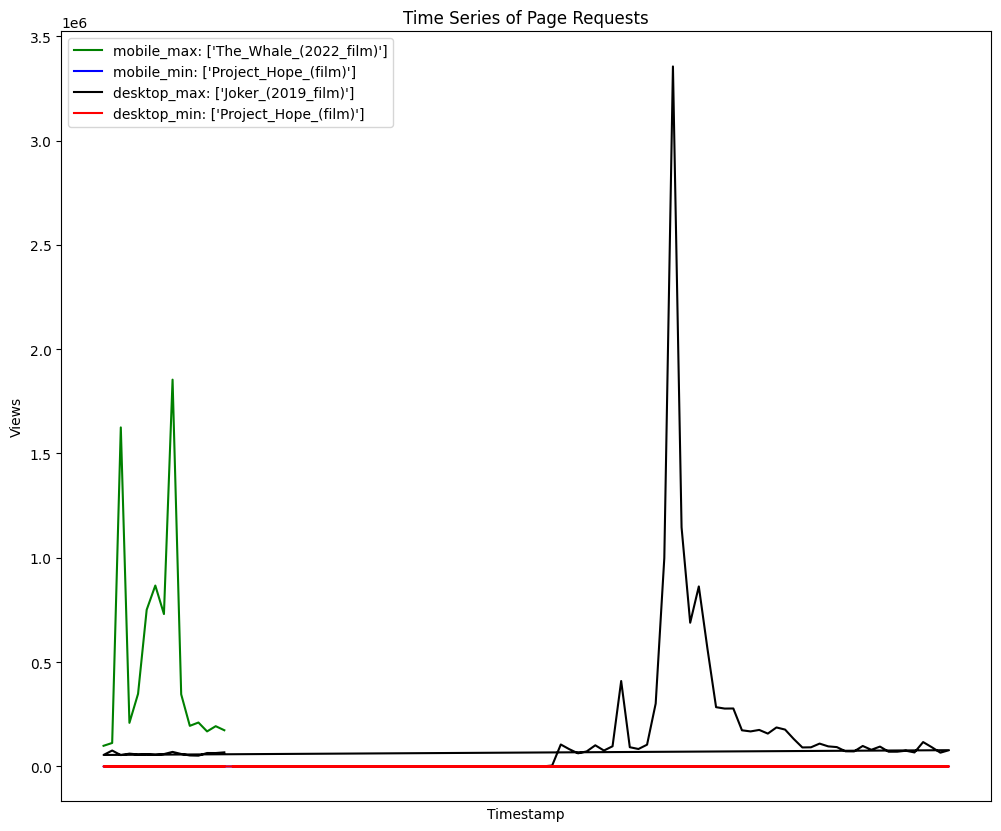

In [29]:
def calculate_max_min_avg(data_df):
  avg_data = data_df.groupby('article')['views'].mean().reset_index()
  max_idx = avg_data['views'].idxmax()
  min_idx = avg_data['views'].idxmin()
  max_data = data_df[data_df['article'] == avg_data.loc[max_idx, 'article']]
  min_data = data_df[data_df['article'] == avg_data.loc[min_idx, 'article']]
  return max_data, min_data


mobile_max_data, mobile_min_data = calculate_max_min_avg(mobile_df)
desktop_max_data, desktop_min_data = calculate_max_min_avg(desktop_df)

plt.figure(figsize=(12, 10))
plt.plot(mobile_max_data['timestamp'], mobile_max_data['views'], label=f"mobile_max: {mobile_max_data['article'].unique()}",color='green')
plt.plot(mobile_min_data['timestamp'], mobile_min_data['views'], label=f"mobile_min: {mobile_min_data['article'].unique()}",color='blue')
plt.plot(desktop_max_data['timestamp'], desktop_max_data['views'], label=f"desktop_max: {desktop_max_data['article'].unique()}",color='black')
plt.plot(desktop_min_data['timestamp'], desktop_min_data['views'], label=f"desktop_min: {desktop_min_data['article'].unique()}",color='red')

plt.xlabel("Timestamp")
plt.xticks([])
plt.ylabel("Views")
plt.title("Time Series of Page Requests")
plt.legend()
plt.savefig("min_max_avg.png")
plt.show()

2.2 **Top 10 Peak Page Views** - The code below produces a graph showing time series for the top 10 article pages by largest (peak) page views over the entire time by access type.

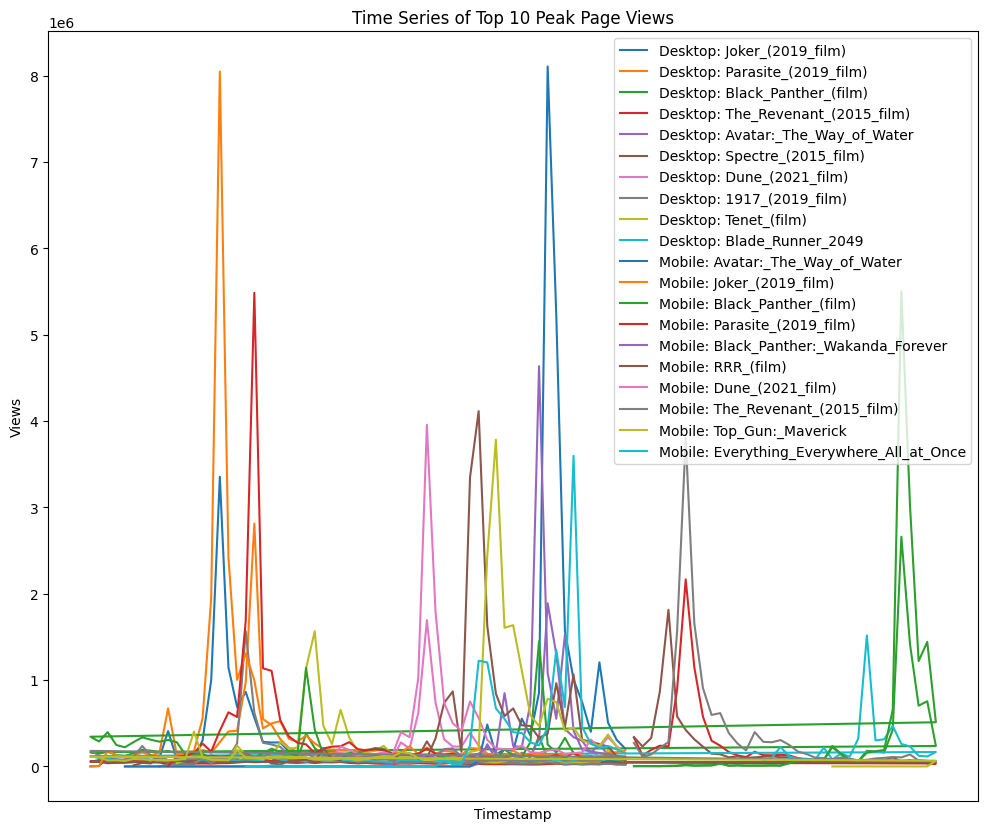

In [27]:
# Find the month with the highest page views for each article for desktop
# and mobile access and fetch corresponding data
def fetch_top_articles(data_df):
  df_peak_month = data_df.groupby('article')['views'].idxmax()
  peak_data = data_df.loc[df_peak_month]
  top_articles = peak_data.nlargest(N,'views')['article']
  return top_articles

top_desktop_articles  = fetch_top_articles(desktop_df)
top_mobile_articles  = fetch_top_articles(mobile_df)


# Extract time series data for the top 10 articles for desktop and mobile access
desktop_top_data = desktop_df[desktop_df['article'].isin(top_desktop_articles)]
mobile_top_data = mobile_df[mobile_df['article'].isin(top_mobile_articles)]


plt.figure(figsize=(12, 10))

# Plot the time series data for desktop access
for article in top_desktop_articles:
    article_data = desktop_top_data[desktop_top_data['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f"Desktop: {article}")

# Plot the time series data for mobile access
for article in top_mobile_articles:
    article_data = mobile_top_data[mobile_top_data['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f"Mobile: {article}")

plt.xticks([])
plt.xlabel("Timestamp")
plt.ylabel("Views")
plt.title("Time Series of Top 10 Peak Page Views")
plt.legend()
plt.savefig("top_10_peak_page_views.png")
plt.show()

2.3 **Fewest Months of Data** - The code below produces a graph for showing the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.


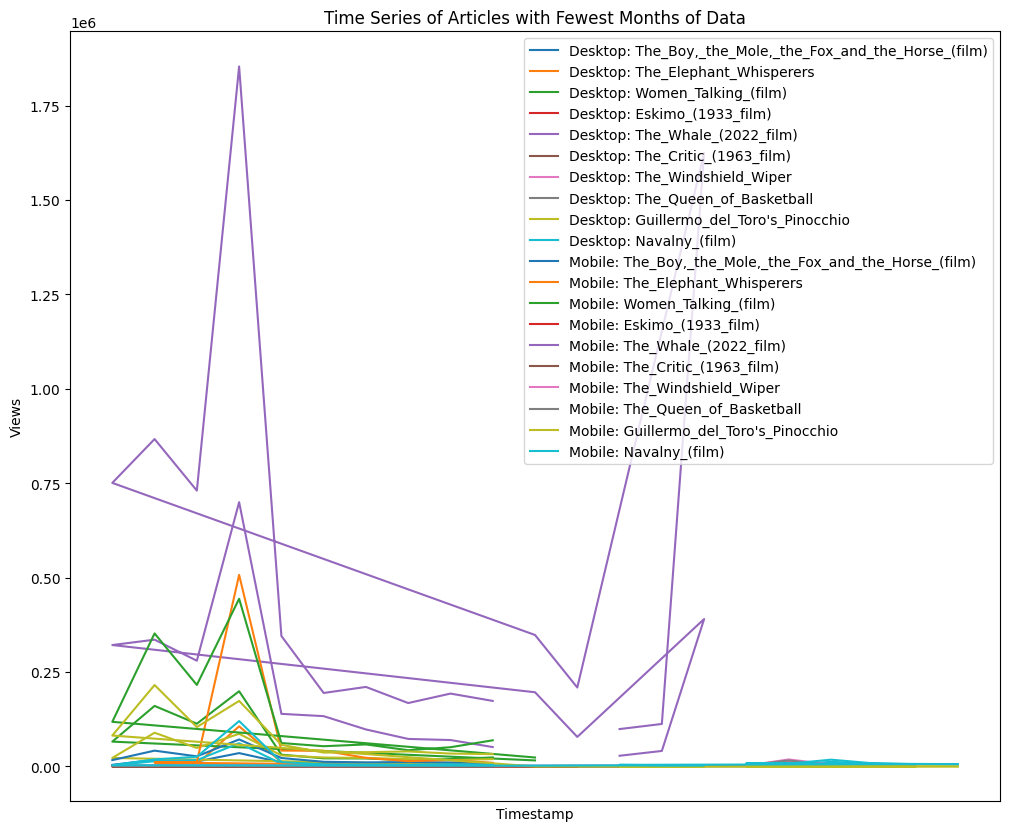

In [31]:
import pandas as pd
import matplotlib.pyplot as plt


def top_articles(data_df):
  data_months = data_df.groupby('article')['timestamp'].count()
  top_articles = data_months.sort_values(ascending=True).head(10).index
  return top_articles

top_desktop_articles = top_articles(desktop_df)
top_mobile_articles = top_articles(mobile_df)

# Fetch time series data for the top 10 articles with the fewest months of data for desktop and mobile access
desktop_top_data = desktop_df[desktop_df['article'].isin(top_desktop_articles)]
mobile_top_data = mobile_df[mobile_df['article'].isin(top_mobile_articles)]

# Create a figure
plt.figure(figsize=(12, 10))

# Plot the time series data for desktop access
for article in top_desktop_articles:
    article_data = desktop_top_data[desktop_top_data['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f"Desktop: {article}")

# Plot the time series data for mobile access
for article in top_mobile_articles:
    article_data = mobile_top_data[mobile_top_data['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f"Mobile: {article}")


plt.xticks([])
plt.xlabel("Timestamp")
plt.ylabel("Views")
plt.title("Time Series of Articles with Fewest Months of Data")
plt.legend()
plt.savefig("fewest_months_data.png")
plt.show()